In [1]:
import torch
import torch.nn.functional as F

def median_filter(image, kernel_size):
    if not isinstance(image, torch.Tensor):
        raise TypeError("Input image must be a torch.Tensor")
    if kernel_size % 2 == 0:
        pad_h1 = (kernel_size - 1) // 2
        pad_h2 = kernel_size // 2
        pad_w1 = (kernel_size - 1) // 2
        pad_w2 = kernel_size // 2
    else:
        pad_h1 = pad_h2 = (kernel_size - 1) // 2
        pad_w1 = pad_w2 = (kernel_size - 1) // 2
    
    padding = (pad_w1, pad_w2, pad_h1, pad_h2)
    
    original_shape = image.shape
    is_2d = image.dim() == 2
    if is_2d:
        image = image.unsqueeze(0).unsqueeze(0)
    elif image.dim() == 3:
        image = image.unsqueeze(0)

    padded_image = F.pad(image, padding, mode='replicate')
    
    unfolded = F.unfold(padded_image, kernel_size=(kernel_size, kernel_size))
    
    unfolded = unfolded.view(image.shape[0], image.shape[1], kernel_size*kernel_size, -1)
    
    median, _ = torch.median(unfolded, dim=2)
    
    filtered_image = median.view(image.shape[0], image.shape[1], image.shape[2], image.shape[3])

    if is_2d:
        return filtered_image.squeeze(0).squeeze(0)
    elif original_shape.dim() == 3:
        return filtered_image.squeeze(0)
    return filtered_image

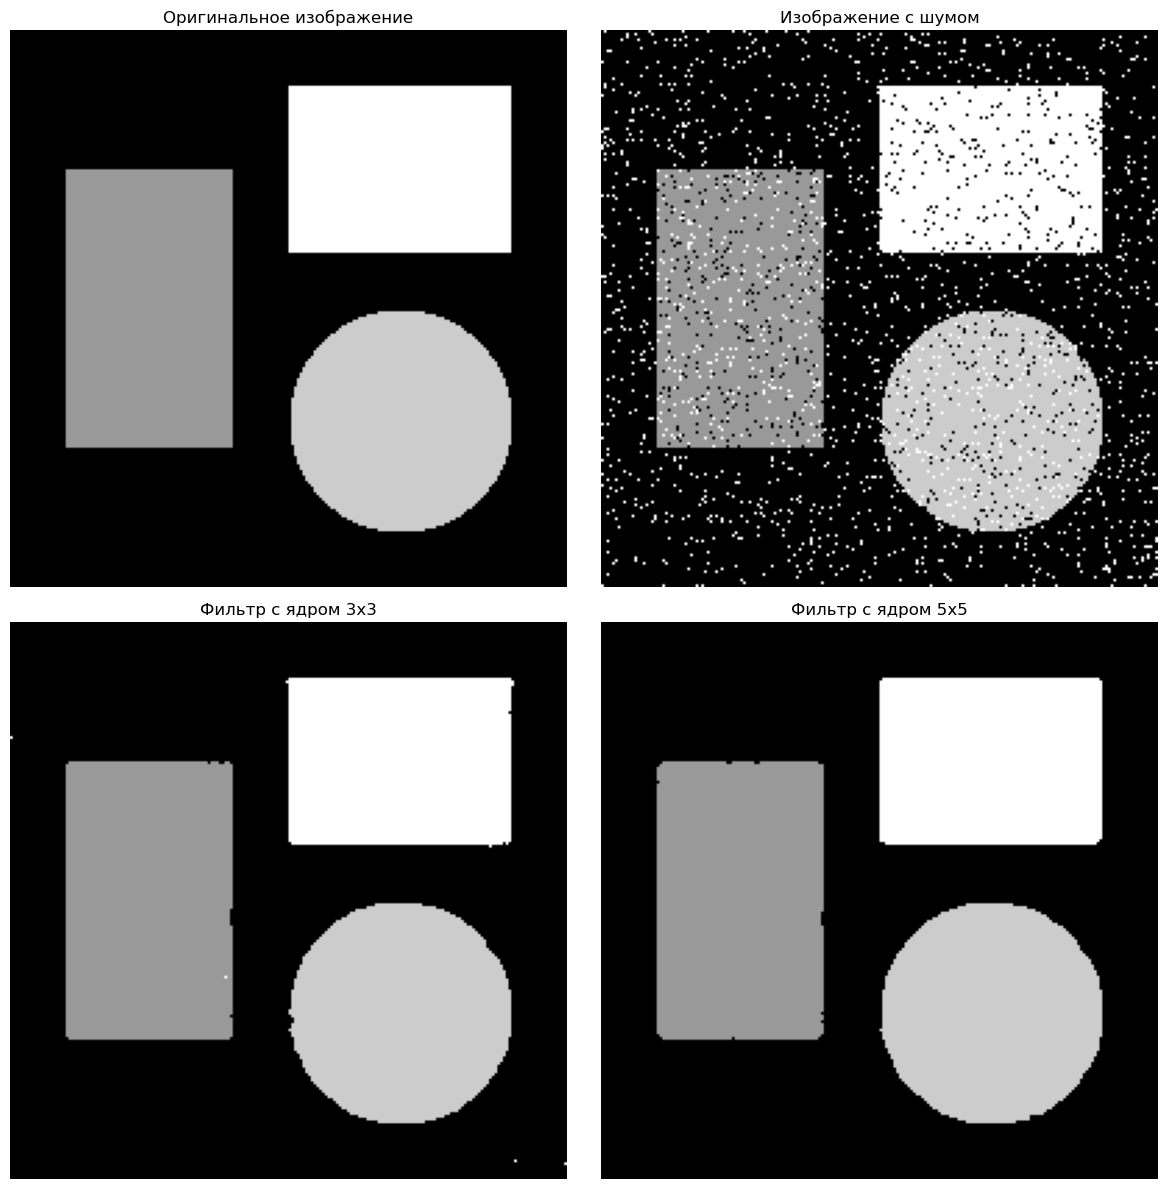

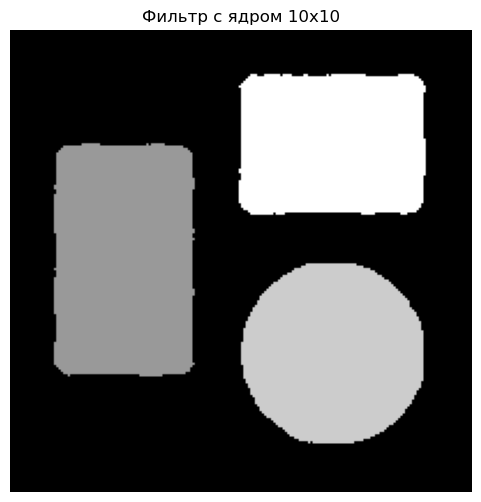

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def add_salt_and_pepper_noise(image, p=0.05):
    noisy_image = image.clone()
    total_pixels = image.numel()
    
    num_salt = int(total_pixels * p * 0.5)
    salt_coords = torch.randint(0, image.numel(), (num_salt,))
    noisy_image.view(-1)[salt_coords] = 1.0

    num_pepper = int(total_pixels * p * 0.5)
    pepper_coords = torch.randint(0, image.numel(), (num_pepper,))
    noisy_image.view(-1)[pepper_coords] = 0.0
    
    return noisy_image

h, w = 200, 200
original_image = torch.zeros((h, w), dtype=torch.float32)
original_image[50:150, 20:80] = 0.6
original_image[20:80, 100:180] = 1.0
cx, cy, r = 140, 140, 40
Y, X = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
mask = (X - cx)**2 + (Y - cy)**2 < r**2
original_image[mask] = 0.8

noisy_image = add_salt_and_pepper_noise(original_image, p=0.1)

kernel_sizes = [3, 5, 10]
filtered_images = [median_filter(noisy_image, k) for k in kernel_sizes]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

axs[0].imshow(original_image, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Оригинальное изображение')
axs[0].axis('off')

axs[1].imshow(noisy_image, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Изображение с шумом')
axs[1].axis('off')

axs[2].imshow(filtered_images[0], cmap='gray', vmin=0, vmax=1)
axs[2].set_title(f'Фильтр с ядром {kernel_sizes[0]}x{kernel_sizes[0]}')
axs[2].axis('off')

axs[3].imshow(filtered_images[1], cmap='gray', vmin=0, vmax=1)
axs[3].set_title(f'Фильтр с ядром {kernel_sizes[1]}x{kernel_sizes[1]}')
axs[3].axis('off')

plt.tight_layout()
plt.show()

fig_large_kernel, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(filtered_images[2], cmap='gray', vmin=0, vmax=1)
ax.set_title(f'Фильтр с ядром {kernel_sizes[2]}x{kernel_sizes[2]}')
ax.axis('off')
plt.show()